In [50]:
# env
library(dplyr)
library(stringr)
library(ggplot2)
#library(tidytext)
library(tidyverse)
#library(jiebaR)
# install.packages("vcd")
library(vcd)

In [51]:
#install.packages("jiebaR")
#install.packages("tidytext")

In [93]:
# analysis
setwd("/content/drive/MyDrive/AAFT_Draft/Data/survey")

cgl_totl <- read.csv("cgl_total.csv")
cgl_actv <- read.csv("cgl_active.csv")
xhl_prof <- read.csv("xhl_profiles.csv")
xhl_post <- read.csv("xhl_posts.csv")

# survey data
sur_clean <- read.csv("sur_clean.csv")
# factor-ize shit
sur_clean$age <- factor(sur_clean$age, levels = c("under 17", "18-24", "25-34", "above 35"))
sur_clean$if_will <- factor(sur_clean$if_will, levels = c("no", "not sure", "yes"))
sur_clean$sham <- factor(sur_clean$sham, levels = c("planning", "have partner", "sham-married"))
sur_clean$mental <- factor(sur_clean$mental, levels = c("none at all", "not significant", "neutral", "fairly significant", "very significant"))
sur_clean$family_exp_marr <- factor(sur_clean$family_exp_marr, levels = c("not at all", "slightly", "neutral", "strong", "extreme"))
sur_clean$family_exp_child <- factor(sur_clean$family_exp_child, levels = c("not at all", "slightly", "neutral", "strong", "extreme"))
sur_clean$pressure_marr <- factor(sur_clean$pressure_marr, levels = c("not at all", "slightly", "neutral", "strong", "extreme"))


In [114]:
# compensate age by time passed by

library(lubridate)

cgl_totl$log <- as.Date(cgl_totl$log)
cgl_totl$quarter <- floor_date(cgl_totl$log, "3 months")
cgl_totl$compensate <- as.numeric(as.Date("2024-06-01") - cgl_totl$log)/365.25
cgl_totl$age_adj <- cgl_totl$age - cgl_totl$compensate


cgl_shft_age <- cgl_totl %>%
  group_by(quarter, gender) %>%
  summarize(mid_age = median(age_adj, na.rm = TRUE),
            mean_age = mean(age_adj, na.rm = T))


`summarise()` has grouped output by 'quarter'. You can override using the
`.groups` argument.


In [100]:
# make income level numeric

install.packages("quantmod")
library(quantmod)

getSymbols("CHNCPIALLMINMEI", src='FRED')
# Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for China

num_income <- function(income) {         # make numeric
  income <- str_trim(income)
  income_numeric <- case_when(
    income == "below 2k"     ~ 1000,
    income == "2k - 3k"      ~ 2500,
    income == "3k - 5k"      ~ 4000,
    income == "5k - 8k"      ~ 6500,
    income == "8k - 12k"     ~ 10000,
    income == "12k - 20k"    ~ 16000,
    income == "20k - 50k"    ~ 35000,
    income == "50k - 100k"   ~ 75000,
    income == 'below 5k'     ~ 2500,     # survey categories
    income == '5k-10k'       ~ 7500,
    income == '10k-20k'      ~ 15000,
    income == 'above 30k'    ~ 30000,
    TRUE                     ~ NA_real_  # NA
  )
  return(income_numeric)
}

cgl_totl <- cgl_totl %>%
  mutate(income_num = num_income(income))

cgl_shft_income <- cgl_totl %>%
  group_by(quarter, gender) %>%
  rename("date" = "quarter") %>%
  summarize(mean_income = mean(income_num, na.rm = TRUE)) %>%
  filter(!is.na(date))

cpi_cn <- data.frame(CHNCPIALLMINMEI)
cpi_cn <- data.frame(date = rownames(cpi_cn), cpi_cn) %>%
  mutate(date = as.Date(date))
rownames(cpi_cn) <- NULL

cgl_shft_income <- cgl_shft_income %>%
  left_join(cpi_cn, join_by(date)) %>%
  rename("cpi" = "CHNCPIALLMINMEI") %>%
  mutate(ad_cpi = cpi / 115.1156) %>%        # row 1 as standard
  mutate(adj_income = mean_income / ad_cpi)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "CHNCPIALLMINMEI"

`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


In [108]:
# for survey

sur_clean <- sur_clean %>%
  mutate(income_num = num_income(income))

# for present users

cgl_actv <- cgl_actv %>%
  mutate(income_num = num_income(income))

[1] 11418.87

[1] 5292.113

[1] 8333.333

In [111]:
t.test(sur_clean$income_num, cgl_actv$income_num)


	Welch Two Sample t-test

data:  sur_clean$income_num and cgl_actv$income_num
t = -3.4265, df = 52.348, p-value = 0.001198
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4892.221 -1278.860
sample estimates:
mean of x mean of y 
 8333.333 11418.874 


# compare sample pool

# distribution

In [53]:
######################### age distribution #########################

readyAgeGroup <- function(dat){
  tmp <- dat %>%
    select(gender, age) %>%
    mutate(age_group = cut(age,
                     breaks = c(-Inf, 17, 24, 34, 44, 54, Inf), # from survey
                     labels = c("under 17", "18-24", "25-34", "35-44", "45-54", "55 and above"))) %>%
    group_by(age_group, gender) %>%
    summarise(ppln = n()) %>%
    mutate(ppln_gender = ifelse(gender == "male", -ppln, ppln)) # group users by age_group and separate by gender

  return(tmp)
}


`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


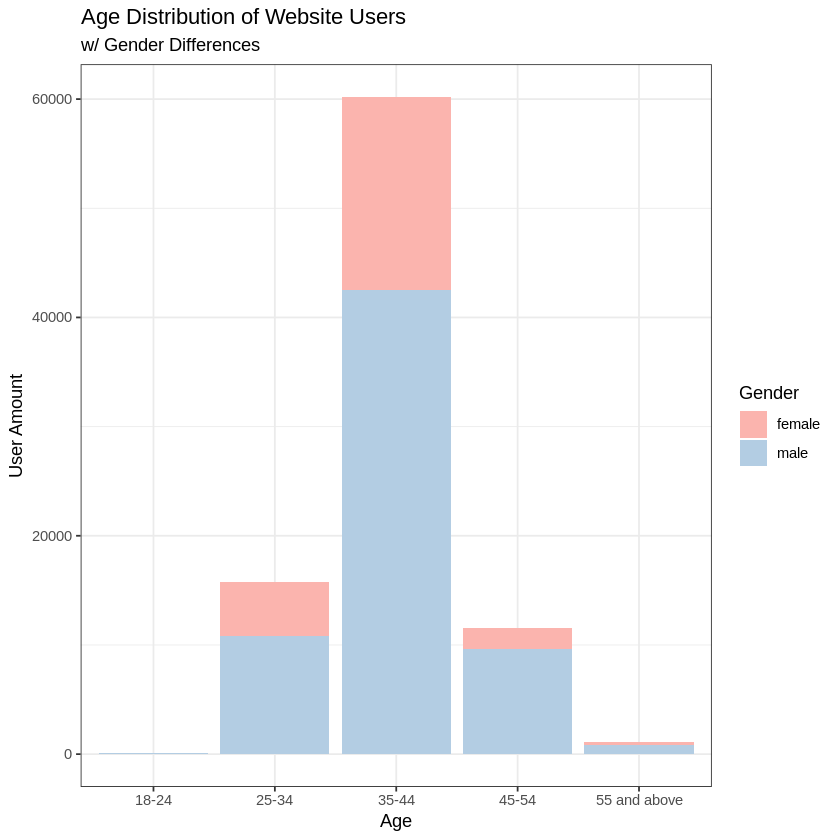

In [54]:
# cgl_totl
cgl_totl_age <- readyAgeGroup(cgl_totl)

ggplot(cgl_totl_age, aes(x = age_group, y = ppln, fill = gender)) +   # y = ppln_gender (split by gender)
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = abs) +
  #coord_flip() +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "Age Distribution of Website Users",
        subtitle = "w/ Gender Differences",
        x = "Age",
        y = "User Amount",
        fill = "Gender") +
  theme_bw()

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


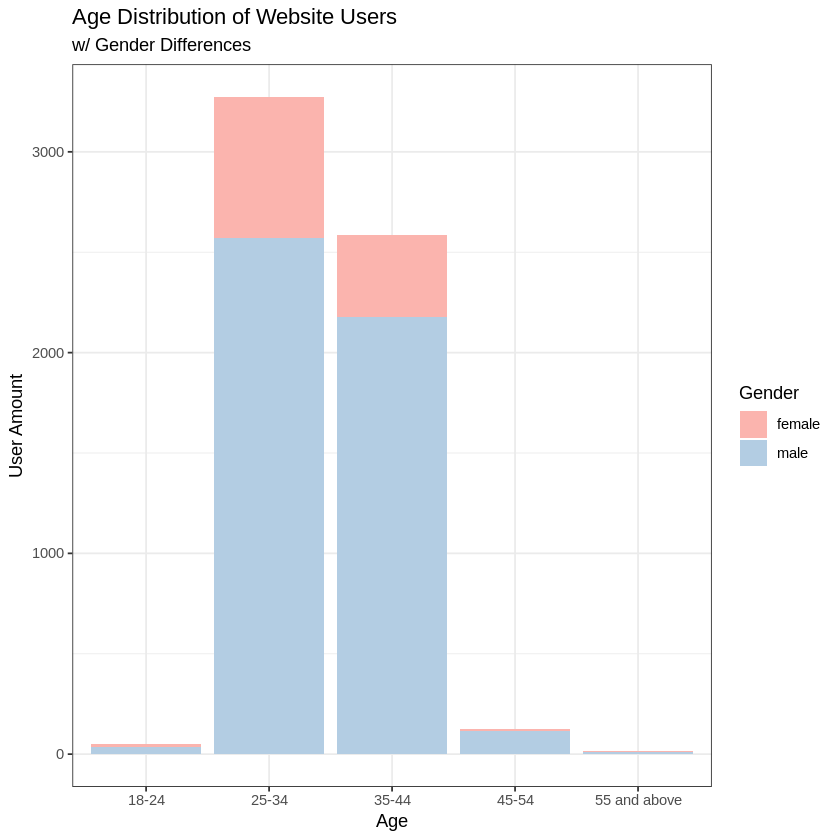

In [55]:
# cgl_active
cgl_actv_age <- readyAgeGroup(cgl_actv)

ggplot(cgl_actv_age, aes(x = age_group, y = ppln, fill = gender)) +   # y = ppln_gender (split by gender)
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = abs) +
  #coord_flip() +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "Age Distribution of Website Users",
        subtitle = "w/ Gender Differences",
        x = "Age",
        y = "User Amount",
        fill = "Gender") +
  theme_bw()

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


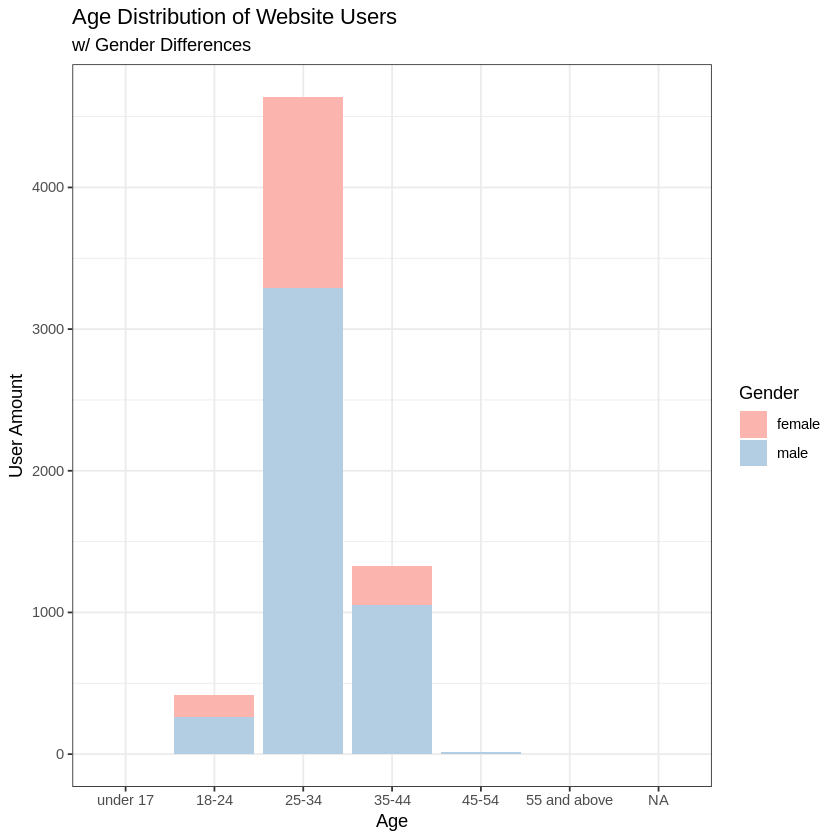

In [56]:
# xhl_post
xhl_post_age <- readyAgeGroup(xhl_post)

ggplot(xhl_post_age, aes(x = age_group, y = ppln, fill = gender)) +   # y = ppln_gender (split by gender)
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = abs) +
  #coord_flip() +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "Age Distribution of Website Users",
        subtitle = "w/ Gender Differences",
        x = "Age",
        y = "User Amount",
        fill = "Gender") +
  theme_bw()

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


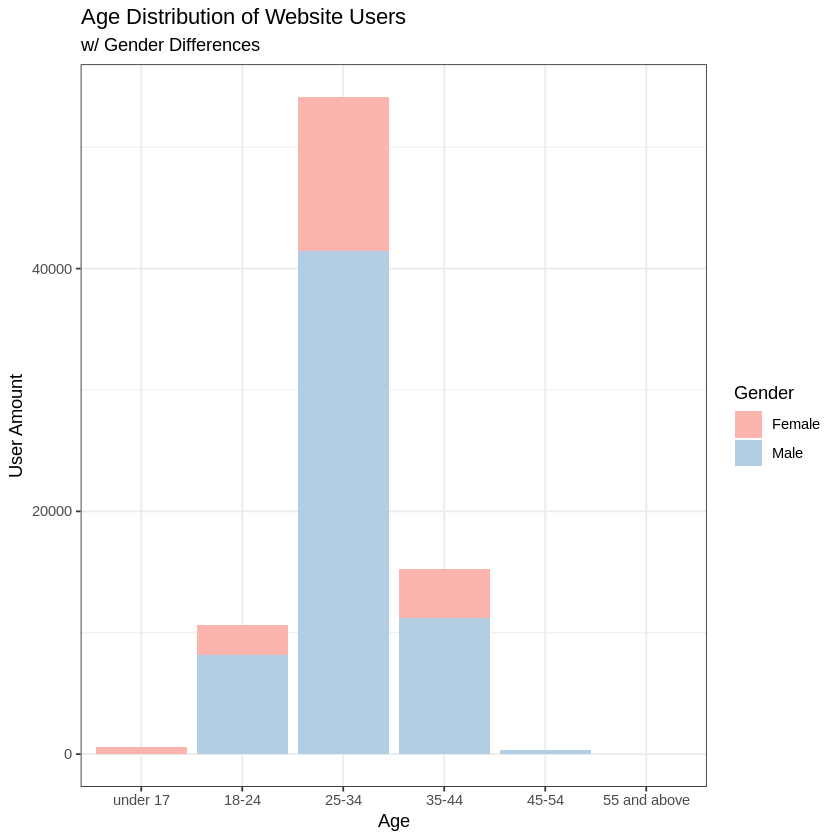

In [57]:
# xhl_prof
xhl_prof_age <- readyAgeGroup(xhl_prof)

ggplot(xhl_prof_age, aes(x = age_group, y = ppln, fill = gender)) +   # y = ppln_gender (split by gender)
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = abs) +
  #coord_flip() +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "Age Distribution of Website Users",
        subtitle = "w/ Gender Differences",
        x = "Age",
        y = "User Amount",
        fill = "Gender") +
  theme_bw()

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


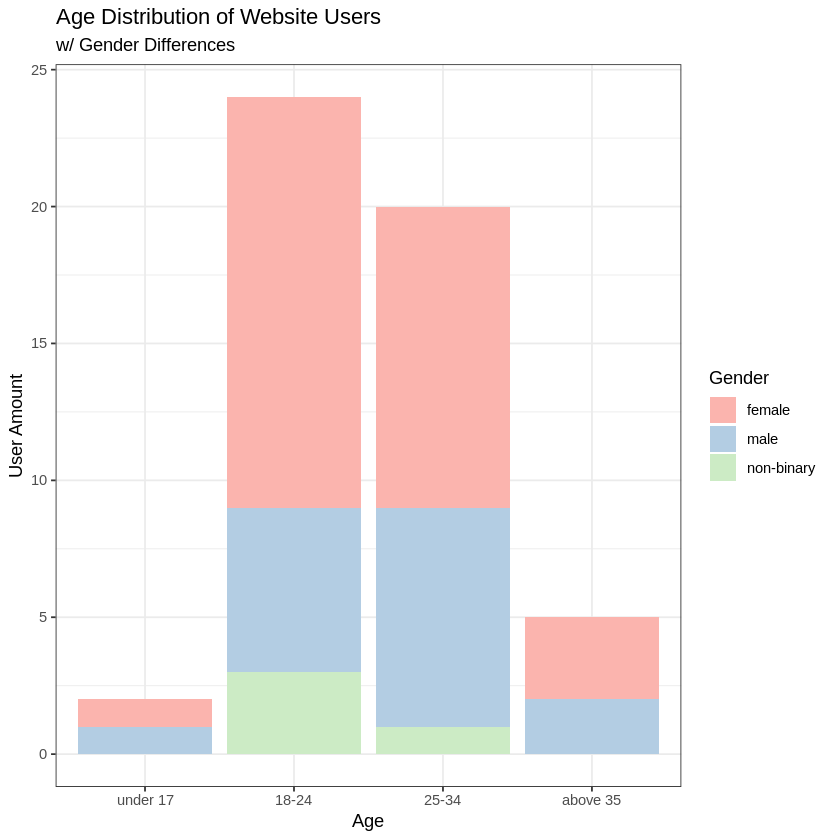

In [58]:
# survey

sur_clean$age <- factor(sur_clean$age, levels = c("under 17", "18-24", "25-34", "above 35"))
sur_age <- sur_clean %>%
  group_by(age, gender) %>%
  summarise(ppln = n())


ggplot(sur_age, aes(x = age, y = ppln, fill = gender)) +   # y = ppln_gender (split by gender)
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = abs) +
  #coord_flip() +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "Age Distribution of Website Users",
        subtitle = "w/ Gender Differences",
        x = "Age",
        y = "User Amount",
        fill = "Gender") +
  theme_bw()

In [71]:
sur_clean

X,age,gender,orientation,partner,edu,marr,income,sham,mental,if_will,parenting,attachment,family_exp_marr,family_exp_child,pressure_marr
<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>
1,18-24,male,bisexual,no,college,single,below 5k,planning,neutral,not sure,authoritative,disorganized,neutral,neutral,not at all
2,18-24,non-binary,bisexual,yes,college,single,5k-10k,planning,neutral,no,uninvolved/neglectful,anxious,strong,strong,strong
3,25-34,female,bisexual,no,college,single,5k-10k,planning,not significant,yes,authoritarian,avoidant,slightly,slightly,NA
4,25-34,female,bisexual,yes,master and above,married,5k-10k,sham-married,very significant,yes,authoritarian,secure,extreme,extreme,extreme
5,18-24,female,homosexual,yes,college associate,single,5k-10k,have partner,fairly significant,yes,authoritative,disorganized,strong,strong,strong
6,18-24,female,bisexual,no,college,single,below 5k,have partner,neutral,no,authoritarian,disorganized,neutral,not at all,NA
7,25-34,female,bisexual,no,college associate,single,below 5k,planning,neutral,no,uninvolved/neglectful,disorganized,not at all,not at all,not at all
8,18-24,female,bisexual,yes,college,single,10k-20k,planning,fairly significant,no,authoritative,disorganized,strong,strong,neutral
9,under 17,male,homosexual,no,high school and/or associate,single,below 5k,planning,neutral,not sure,authoritative,secure,neutral,neutral,neutral


# activity

`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


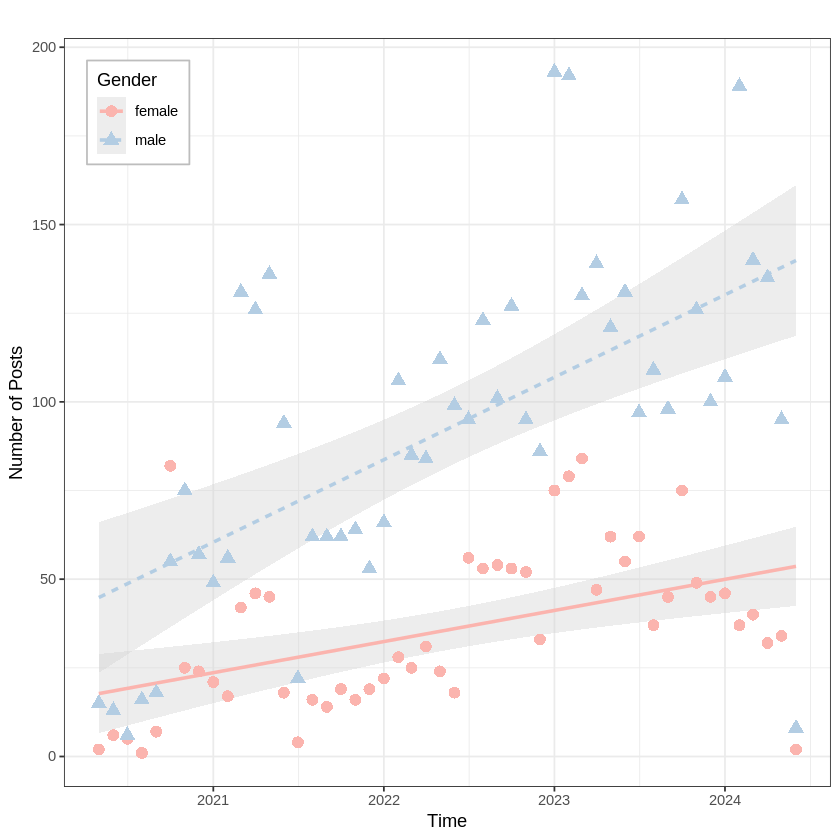

In [59]:
######################### user activity analysis #########################

# xhl posts
library(lubridate)

xhl_post_freq <- xhl_post %>%
  mutate(date = as.Date(date)) %>%
  mutate(month = floor_date(date, "month")) %>%
  group_by(month, gender) %>%
  summarize(count = n())

user1 <- ggplot(xhl_post_freq, aes(x = month, y = count)) +
  geom_smooth(method = lm, aes(color = gender, linetype = gender), fill = "light grey", alpha = 0.4) +
  geom_point(aes(shape = gender, color = gender), size = 3) +
  scale_color_brewer(palette = "Pastel1") +
  labs(title = "",
       x = "Time",
       y = "Number of Posts",
       color = "Gender",
       shape = "Gender",
       linetype = "Gender") +
  theme_bw() +
  theme(
      panel.background = element_rect(fill = "white", color = NA), # white plot area
      plot.background = element_rect(fill = NA, color = NA),
      legend.position = c(.03, .97),
      legend.justification = c("left", "top"),
      legend.box.just = "left",
      legend.margin = margin(6, 6, 6, 6),
      legend.background = element_rect(fill = "white", color = "#BDBDBD"))

user1

In [129]:
ggsave("poster_1.png", plot = user1, width = 4, height = 4, units = "in", bg = "transparent")

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


`summarise()` has grouped output by 'reg'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'log'. You can override using the `.groups`
argument.


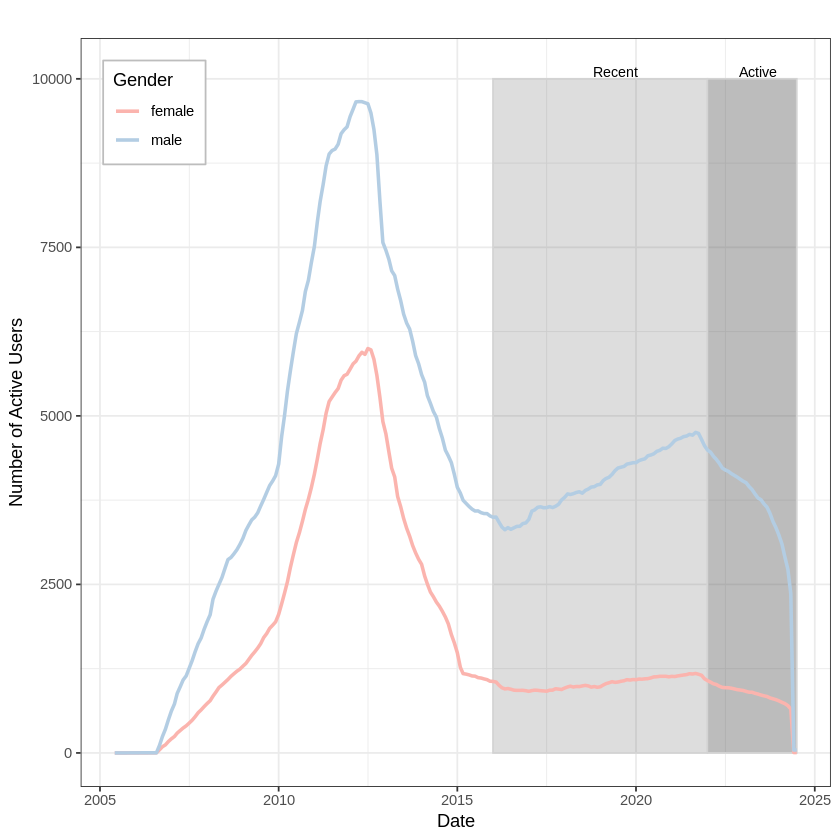

In [61]:
cgl_totl_reg <- cgl_totl %>%
  mutate(reg = floor_date(as.Date(reg), "month")) %>%
  group_by(reg, gender) %>%
  summarize(reg_users = n()) %>%
  rename("date" = "reg")

cgl_totl_log <- cgl_totl %>%
  mutate(log = floor_date(as.Date(log), "month")) %>%
  group_by(log, gender) %>%
  summarize(log_users = n()) %>%
  rename("date" = "log")

dates <- seq(as.Date("2005-06-01"), as.Date("2024-07-01"), by = "month")
gender <- c("female", "male")
cgl_totl_freq <- expand.grid(date = dates, gender = gender)

cgl_totl_freq <- left_join(cgl_totl_freq, cgl_totl_reg, by = c("date", "gender"))
cgl_totl_freq <- left_join(cgl_totl_freq, cgl_totl_log, by = c("date", "gender"))
cgl_totl_freq[is.na(cgl_totl_freq)] <- 0

cgl_totl_freq <- cgl_totl_freq %>%
  arrange(date) %>%
  group_by(gender) %>%
  mutate(cum_reg_users = cumsum(reg_users),
         cum_log_users = cumsum(log_users)) %>%
  ungroup()

cgl_totl_freq <- cgl_totl_freq %>%
  mutate(active_users = cum_reg_users - cum_log_users)

user2 <- ggplot(cgl_totl_freq) +
  annotate("rect",
            xmin = as.Date("2016-01-01"),
            xmax = as.Date("2022-01-01"),
            ymin = 0,
            ymax = 10000,
            alpha = 0.2,
            color = "lightgrey") +
  annotate("rect",
            xmin = as.Date("2022-01-01"),
            xmax = as.Date("2024-07-01"),
            ymin = 0,
            ymax = 10000,
            alpha = 0.4,
            color = "lightgrey") +
  geom_line(aes(x = date, y = active_users, color = gender), size = 1) +
  annotate("text",
            x = as.Date("2019-06-01"),
            y = 10100,
            label = "Recent",
            color = "black", size = 3) +
  annotate("text",
            x = as.Date("2023-06-01"),
            y = 10100,
            label = "Active",
            color = "black", size = 3) +
  labs(title = "",
       x = "Date",
       y = "Number of Active Users",
       color = "Gender") +
  scale_color_brewer(palette = "Pastel1") +
  theme_bw() +
  theme(
      panel.background = element_rect(fill = "white", color = NA), # white plot area
      plot.background = element_rect(fill = NA, color = NA),
      legend.position = c(.03, .97),
      legend.justification = c("left", "top"),
      legend.box.just = "left",
      legend.margin = margin(6, 6, 6, 6),
      legend.background = element_rect(fill = "white", color = "#BDBDBD"))

user2

In [128]:
ggsave("poster_2.png", plot = user2, width = 4, height = 4, units = "in", bg = "transparent")

# useless stuff

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `partner_age_lower = as.numeric(sub(".*?(\\d+)～.*", "\\1",
  par_age))`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `partner_height_lower = as.numeric(sub(".*?(\\d+)～.*", "\\1",
  par_height))`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


[1] "Correlation between male user's age and partner's desired age: 0.71631224037613"
[1] "Correlation between female user's age and partner's desired age: 0.775703790543467"
[1] "Correlation between male user's height and partner's desired height: 0.57990232989859"
[1] "Correlation between female user's height and partner's desired height: 0.285268952172617"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 15 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 15 rows containing missing values or values outside the scale range
(`geom_point()`).”


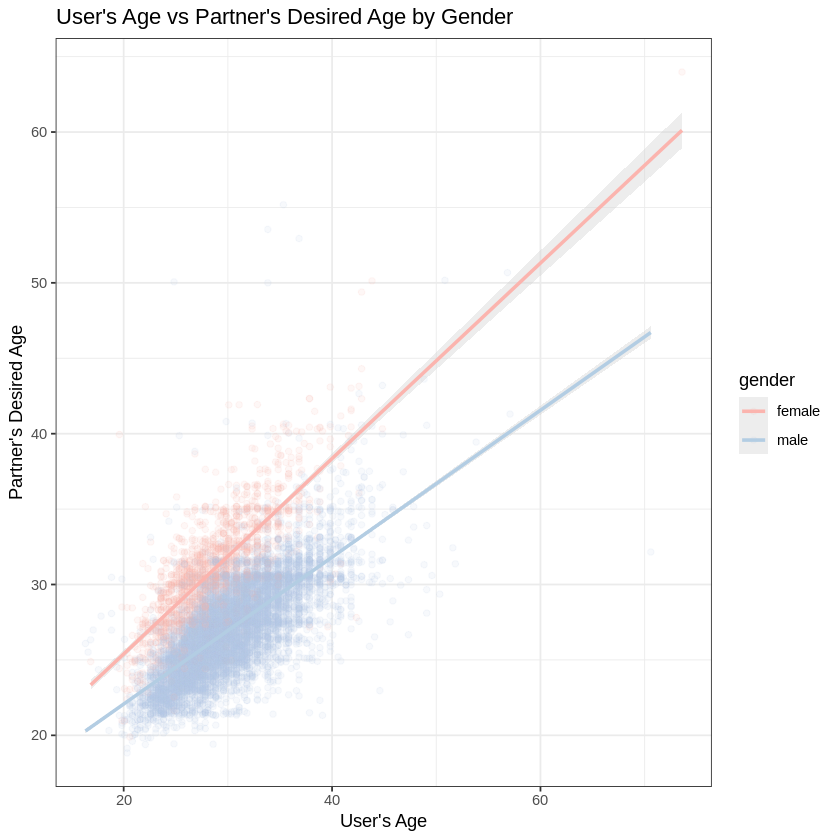

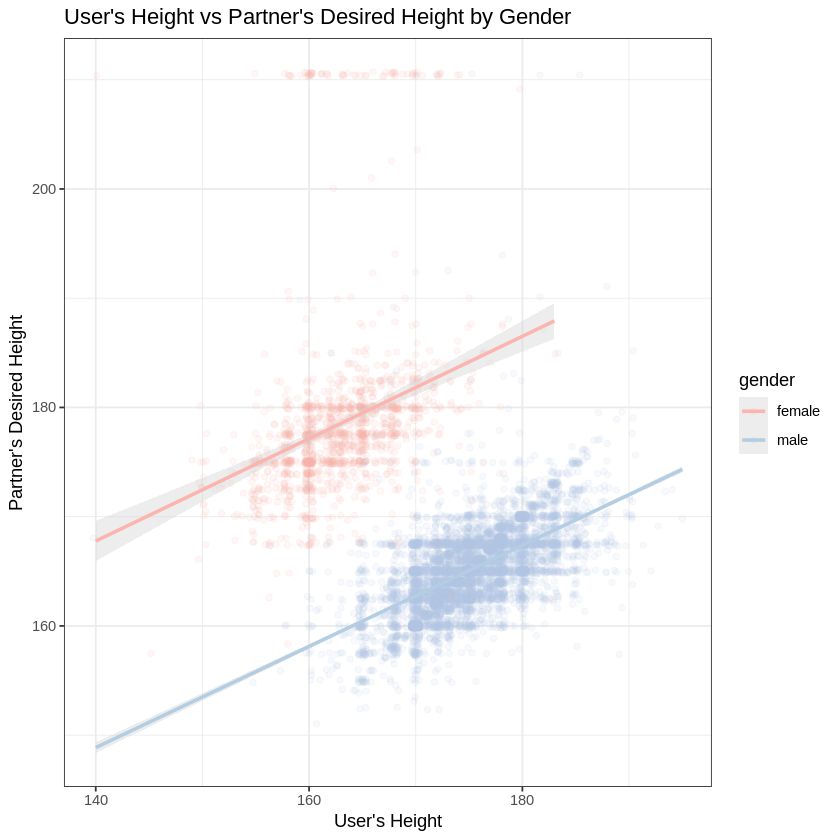

In [63]:
data <- cgl_totl

# Filter rows where 'par_age' contains "岁"
filtered_data <- data %>% filter(grepl("岁", par_age))

# Extract lower and upper bounds for partner's age
filtered_data <- filtered_data %>%
  mutate(
    partner_age_lower = as.numeric(sub(".*?(\\d+)～.*", "\\1", par_age)),
    partner_age_upper = as.numeric(sub(".*～(\\d+)岁.*", "\\1", par_age))
  )

# Extract lower and upper bounds for partner's height
filtered_data <- filtered_data %>%
  mutate(
    partner_height_lower = as.numeric(sub(".*?(\\d+)～.*", "\\1", par_height)),
    partner_height_upper = as.numeric(sub(".*～(\\d+)cm.*", "\\1", par_height))
  )

# Clean the data: Convert user's age and height to numeric
filtered_data <- filtered_data %>%
  mutate(
    user_age = as.numeric(age_adj),
    user_height = as.numeric(height)
  )

# Filter out rows with missing values in critical columns
filtered_data <- filtered_data %>%
  filter(!is.na(user_age), !is.na(user_height), !is.na(partner_age_lower), !is.na(partner_height_lower)) %>%
  filter(!par_height < 140) %>%
  filter(!height < 140)

# Calculate average desired partner age and height
filtered_data <- filtered_data %>%
  mutate(
    avg_partner_age = (partner_age_lower + partner_age_upper) / 2,
    avg_partner_height = (partner_height_lower + partner_height_upper) / 2
  )

# Correlation analysis by gender
cor_age_male <- cor(filtered_data$user_age[filtered_data$gender == "male"],
                    filtered_data$avg_partner_age[filtered_data$gender == "male"],
                    use = "complete.obs")
cor_age_female <- cor(filtered_data$user_age[filtered_data$gender == "female"],
                      filtered_data$avg_partner_age[filtered_data$gender == "female"],
                      use = "complete.obs")
cor_height_male <- cor(filtered_data$user_height[filtered_data$gender == "male"],
                       filtered_data$avg_partner_height[filtered_data$gender == "male"],
                       use = "complete.obs")
cor_height_female <- cor(filtered_data$user_height[filtered_data$gender == "female"],
                         filtered_data$avg_partner_height[filtered_data$gender == "female"],
                         use = "complete.obs")

# Print correlation results
print(paste("Correlation between male user's age and partner's desired age:", cor_age_male))
print(paste("Correlation between female user's age and partner's desired age:", cor_age_female))
print(paste("Correlation between male user's height and partner's desired height:", cor_height_male))
print(paste("Correlation between female user's height and partner's desired height:", cor_height_female))

# Visualization: Age vs Partner's Desired Age by Gender
ggplot(filtered_data, aes(x = user_age, y = avg_partner_age, color = gender)) +
  geom_jitter(alpha = 0.1) +
  geom_smooth(method = "lm", fill = "lightgrey", aes(group = gender)) +
  scale_color_brewer(palette = "Pastel1") +
  labs(title = "User's Age vs Partner's Desired Age by Gender",
       x = "User's Age",
       y = "Partner's Desired Age") +
  theme_bw()

# Visualization: Height vs Partner's Desired Height by Gender
ggplot(filtered_data, aes(x = user_height, y = avg_partner_height, color = gender)) +
  geom_jitter(alpha = 0.1) +
  geom_smooth(method = "lm", fill = "lightgrey", aes(group = gender)) +
  scale_color_brewer(palette = "Pastel1") +
  labs(title = "User's Height vs Partner's Desired Height by Gender",
       x = "User's Height",
       y = "Partner's Desired Height") +
  theme_bw()


In [64]:
######################### more data cleaning for income #########################
cgl_totl$par_income <- cgl_totl$par_income %>%
  gsub("2000元以下", "below 2k", .) %>%
  gsub("2000～3000元", "2k - 3k", .) %>%
  gsub("8000～12000元", "8k - 12k", .) %>%
  gsub("3000～5000元", "3k - 5k", .) %>%
  gsub("5000～8000元", "5k - 8k", .) %>%
  gsub("2万元以上", "above 20k", .) %>%
  gsub("12000～20000元", "12k - 20k", .) %>%
  gsub("5万～10万元", "50k - 100k", .) %>%
  gsub("2万～5万元", "20k - 50k", .) %>%
  gsub("20万元以上", "above 200k", .) %>%
  gsub("10万～20万元", "100k - 200k", .) %>%
  factor(levels = c("below 2k", "2k - 3k", "3k - 5k", "5k - 8k", "8k - 12k",
                    "12k - 20k", "20k - 50k", "50k - 100k", "100k - 200k", "above 20k", "above 200k"))

# Function to convert income strings to numeric
convert_income_to_numeric <- function(income_str) {
  # Remove spaces for uniformity
  income_str <- gsub(" ", "", income_str)

  # Handle ranges like "5k - 8k"
  if (grepl("-", income_str)) {
    bounds <- strsplit(income_str, "-")[[1]]
    lower_bound <- as.numeric(gsub("k", "", bounds[1])) * 1000
    upper_bound <- as.numeric(gsub("k", "", bounds[2])) * 1000
    return((lower_bound + upper_bound) / 2) # Return the average
  }

  # Handle "above Xk" cases
  if (grepl("above", income_str)) {
    numeric_part <- as.numeric(gsub("k", "", gsub("above", "", income_str))) * 1000
    return(numeric_part + 5000) # Approximate by adding 5000 to the base value
  }

  # Handle "below Xk" cases
  if (grepl("below", income_str)) {
    numeric_part <- as.numeric(gsub("k", "", gsub("below", "", income_str))) * 1000
    return(numeric_part - 1000) # Approximate by subtracting 1000 from the base value
  }

  # Handle single values like "20k"
  if (grepl("k", income_str)) {
    return(as.numeric(gsub("k", "", income_str)) * 1000)
  }

  return(NA) # Return NA if none of the above cases apply
}

# Apply the function to the income column in the dataset
cgl_totl <- cgl_totl %>%
  mutate(income_numeric = sapply(income, convert_income_to_numeric)) %>%
  mutate(par_income_numeric = sapply(par_income, convert_income_to_numeric))

###########################################################################

#write.csv(cgl_totl, "/content/drive/MyDrive/AAFT_Draft/Data/survey/cgl_total.csv")

# more plots

In [65]:
######################### data for Qs comparison #########################

rasterComp <- function(dat, colx, coly){        # get two columns for comparison
  sur_tmp <- dat %>%                            # need to present in sur_clean
    group_by({{colx}}, {{coly}}) %>%            # if not: modify data cleaning by the end of page
    summarise(case = n()) %>%
    ungroup() %>%
    group_by({{coly}}) %>%
    mutate(total = sum(case),
           prop = case / total)

  supple <- expand.grid(                        # fill empty entires with NA for blank bg
    x = unique(dat %>% pull({{colx}})),
    y = unique(dat %>% pull({{coly}}))
  )

  colnames(supple) <- c(rlang::as_label(rlang::enquo(colx)),
                        rlang::as_label(rlang::enquo(coly)))

  sur_tmp <- supple %>%
    left_join(sur_tmp, by = c(rlang::as_label(rlang::enquo(colx)), rlang::as_label(rlang::enquo(coly)))) %>%
    replace_na(list(prop = NA))

  if(class(sur_tmp %>% pull({{colx}})) != "factor"){      # check if the variables are factorized
      cat("Remember to factorize axis labels.")         # ensure ticks are properly marked
  }

  return(sur_tmp)
}

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


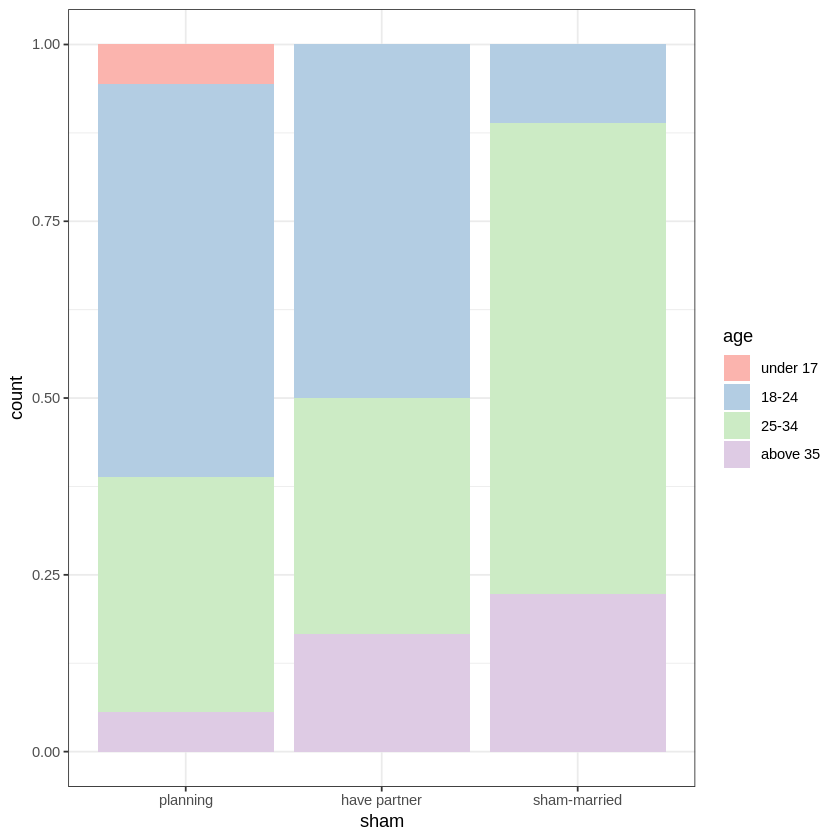

In [66]:
# sham status vs. age group

sur_sham <- rasterComp(sur_clean, age, sham)

sur_sham$age <- factor(sur_sham$age, levels = c("under 17", "18-24", "25-34", "above 35"))
sur_sham$sham <- factor(sur_sham$sham, levels = c("planning", "have partner", "sham-married"))

#ggplot(sur_sham, aes(x = age, y = sham, fill = prop)) +
#  geom_raster() +
#  coord_fixed() +
#  scale_fill_gradient2(na.value = "white") +
#  labs(title = "Participant Age and Sham Marriage Status",
#       subtitle = "",
#       x = "Age Group",
#       y = "Sham Marriage Status",
#       fill = "Proportion") +
#  theme_bw()

# bar graph
bar1 <- ggplot(sur_clean %>% select(age, sham), aes(x = sham, fill = age)) +
  geom_bar(position = "fill", width = 0.9) +
  scale_fill_brewer(palette = "Pastel1") +
#  labs(title = "Participant Age and Sham Marriage Status",
#       subtitle = "",
#       y = "",
#       x = "Sham Marriage Status",
#       fill = "Age Groups") +
  theme_bw()

bar1

In [ ]:
# mass chi sq

# Create a matrix to store p-values
chi_sq_results <- matrix(NA, nrow = ncol(sur_clean), ncol = ncol(sur_clean))
colnames(chi_sq_results) <- colnames(sur_clean)
rownames(chi_sq_results) <- colnames(sur_clean)

# Loop through all pairs of columns
for (i in 1:ncol(sur_clean)) {
  for (j in 1:ncol(sur_clean)) {
    if (i != j) {
      # Perform Chi-Square test
      chi_sq_test <- chisq.test(table(sur_clean[, i], sur_clean[, j]))
      # Store the p-value
      chi_sq_results[i, j] <- chi_sq_test$p.value
    }
  }
}

chi_sq_results  # This matrix contains the p-values for each pair of variables

Warning message in chisq.test(table(sur_clean[, i], sur_clean[, j])):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sur_clean[, i], sur_clean[, j])):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sur_clean[, i], sur_clean[, j])):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sur_clean[, i], sur_clean[, j])):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sur_clean[, i], sur_clean[, j])):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sur_clean[, i], sur_clean[, j])):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sur_clean[, i], sur_clean[, j])):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sur_clean[, i], sur_clean[, j])):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(table(sur_clean[, i], sur_clean[, j])):
“Chi-squar

,X,age,gender,orientation,partner,edu,marr,income,sham,mental,if_will,parenting,attachment,family_exp_marr,family_exp_child,pressure_marr
X,NA,0.4166378281,0.42560514,0.43409393,0.434093935,0.40828137,0.4340939350,0.41663783,0.425605140,NaN,0.42560514,0.41663783,0.41663783,4.082814e-01,4.082814e-01,NaN
age,0.4166378,NA,0.86268846,0.01710624,0.039185630,0.06061200,0.0008030704,0.19766566,0.214591863,0.2507724520,0.15749778,0.02764395,0.45531435,2.732737e-02,7.179849e-01,9.589362e-02
gender,0.4256051,0.8626884582,NA,0.42640695,0.452075861,0.56425568,0.4395058519,0.04037166,0.064666362,0.7235634053,0.22967464,0.27489952,0.03364654,6.846114e-01,4.001310e-01,8.770226e-01
orientation,0.4340939,0.0171062366,0.42640695,NA,0.091152492,0.87235340,0.1008829083,0.47756417,0.024941961,0.0805445766,0.48319988,0.20790705,0.30211992,8.579690e-02,1.210496e-01,1.935338e-01
partner,0.4340939,0.0391856298,0.45207586,0.09115249,NA,0.41839924,0.1680045367,0.20572710,0.029870928,0.0854991535,0.09820620,0.34947277,0.16248376,1.120296e-01,2.334386e-02,9.351952e-03
edu,0.4082814,0.0606120035,0.56425568,0.87235340,0.418399240,NA,0.3438964107,0.01030038,0.935992268,0.3335859909,0.74073763,0.12420611,0.06990710,2.842281e-01,7.463533e-01,6.091595e-01
marr,0.4340939,0.0008030704,0.43950585,0.10088291,0.168004537,0.34389641,NA,0.17089978,0.014559837,0.3134578335,0.23004587,0.68207610,0.78032727,7.228157e-01,1.125356e-01,6.503373e-02
income,0.4166378,0.1976656567,0.04037166,0.47756417,0.205727102,0.01030038,0.1708997824,NA,0.184844520,0.2769010426,0.74057353,0.33603143,0.45175515,5.944614e-01,6.478521e-01,6.911204e-01
sham,0.4256051,0.2145918632,0.06466636,0.02494196,0.029870928,0.93599227,0.0145598372,0.18484452,NA,0.0047300441,0.01354008,0.76643515,0.15380172,5.850326e-01,1.309159e-01,3.298671e-01
mental,NaN,0.2507724520,0.72356341,0.08054458,0.085499153,0.33358599,0.3134578335,0.27690104,0.004730044,NA,0.55396508,0.35147687,0.37463278,6.400696e-04,5.321986e-02,4.331480e-02


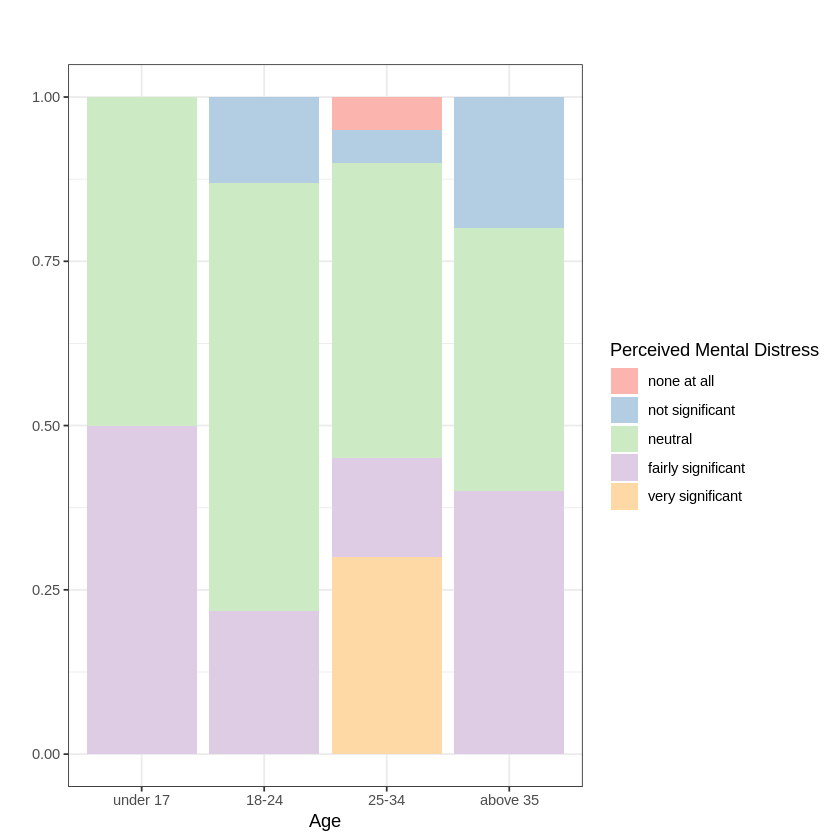

In [120]:
# sham status vs. mental

bar1 <- ggplot(sur_clean %>% filter(!is.na(age)) %>% filter(!is.na(mental)), aes(x = age, fill = mental)) +
  geom_bar(position = "fill", width = 0.9) +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "",
       subtitle = "",
       x = "Age",
       y = "",
       fill = "Perceived Mental Distress") +
  theme_bw() +
  theme(
      panel.background = element_rect(fill = "white", color = NA), # white plot area
      plot.background = element_rect(fill = NA, color = NA)) +
  theme(
      panel.background = element_rect(fill = "white", color = NA), # white plot area
      plot.background = element_rect(fill = NA, color = NA))

bar1

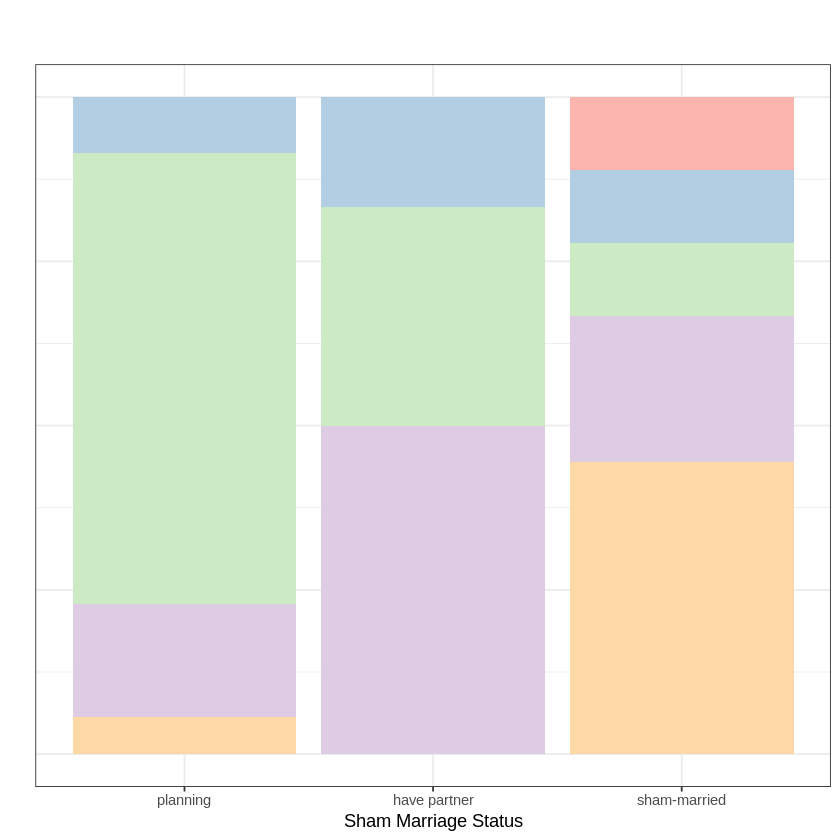

In [126]:
# sham status vs. mental

#sur_mental <- rasterComp(sur_clean, sham, mental)

bar2 <- ggplot(sur_clean %>% filter(!is.na(sham)) %>% filter(!is.na(mental)), aes(x = sham, fill = mental)) +
  geom_bar(position = "fill", width = 0.9) +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "",
       subtitle = "",
       x = "Sham Marriage Status",
       y = "",
       fill = "Perceived Mental Distress") +
  theme_bw() +
  theme(
      panel.background = element_rect(fill = "white", color = NA), # white plot area
      plot.background = element_rect(fill = NA, color = NA),
      legend.position = "none",
      axis.text.y = element_blank(),
      axis.ticks.y = element_blank())

bar2

In [127]:
ggsave("poster_5.png", plot = bar2, width = 4, height = 5, units = "in", bg = "transparent")

In [ ]:
sham_mental_table <- table(sur_clean$sham, sur_clean$mental)
chi_test_result <- chisq.test(sham_mental_table)

print(chi_test_result)

assocstats(sham_mental_table)
# sig

Warning message in chisq.test(sham_mental_table):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  sham_mental_table
X-squared = 22.102, df = 8, p-value = 0.00473



                    X^2 df P(> X^2)
Likelihood Ratio 19.592  8 0.011997
Pearson          22.102  8 0.004730

Phi-Coefficient   : NA 
Contingency Coeff.: 0.554 
Cramer's V        : 0.47 

`summarise()` has grouped output by 'if_will'. You can override using the
`.groups` argument.


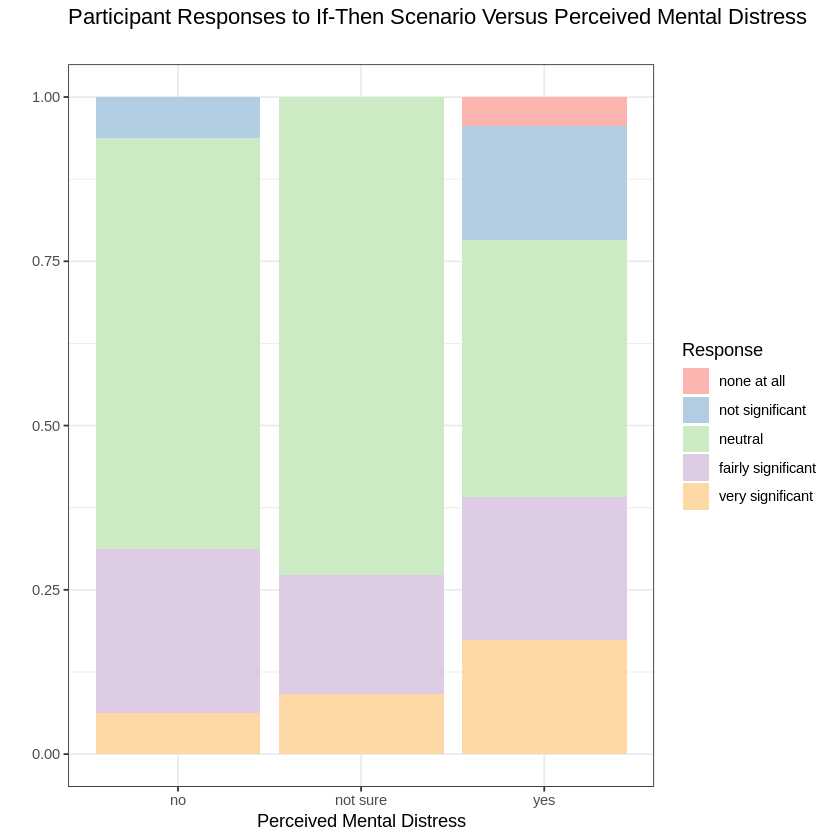

In [ ]:
# mental impact vs. if_will choose again

sur_if <- rasterComp(sur_clean, if_will, mental)

sur_if$mental <- factor(sur_if$mental, levels = c("none at all", "not significant", "neutral", "fairly significant", "very significant"))
sur_if$if_will <- factor(sur_if$if_will, levels = c("no", "not sure", "yes"))

# bar graph
bar3 <- ggplot(sur_clean %>% filter(!is.na(if_will)) %>% filter(!is.na(mental)), aes(x = if_will, fill = mental)) +
  geom_bar(position = "fill", width = 0.9) +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "Participant Responses to If-Then Scenario Versus Perceived Mental Distress",
       subtitle = "",
       x = "Perceived Mental Distress",
       y = "",
       fill = "Response") +
  theme_bw()

bar3

In [ ]:
if_mental_table <- table(sur_clean$if_will, sur_clean$mental)
chi_test_result_2 <- chisq.test(if_mental_table)

print(chi_test_result_2)
assocstats(if_mental_table)

# nope

Warning message in chisq.test(if_mental_table):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  if_mental_table
X-squared = 6.8402, df = 8, p-value = 0.554



                    X^2 df P(> X^2)
Likelihood Ratio 8.1795  8  0.41614
Pearson          6.8402  8  0.55397

Phi-Coefficient   : NA 
Contingency Coeff.: 0.347 
Cramer's V        : 0.262 

In [ ]:
#ggsave("bar_plot3.png", plot = bar3, width = 10, height = 10, units = "in")

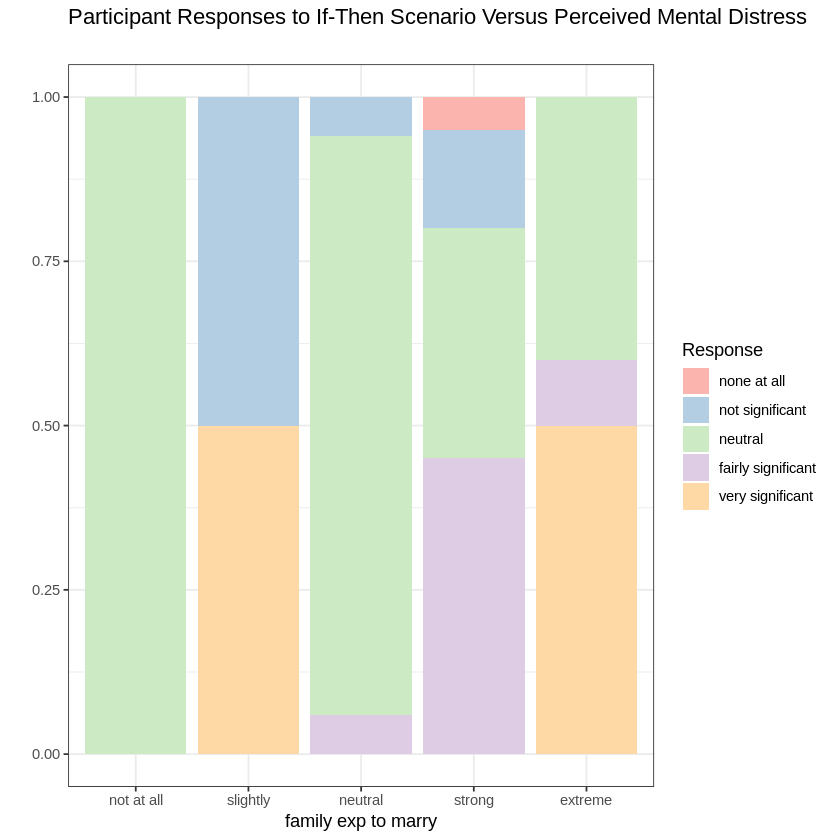

In [ ]:
bar4 <- ggplot(sur_clean %>% filter(!is.na(family_exp_marr)) %>% filter(!is.na(mental)),
                aes(x = family_exp_marr, fill = mental)) +
  geom_bar(position = "fill", width = 0.9) +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "Participant Responses to If-Then Scenario Versus Perceived Mental Distress",
       subtitle = "",
       x = "family exp to marry",
       y = "",
       fill = "Response") +
  theme_bw()

bar4

In [ ]:
exp_mental_table <- table(sur_clean$family_exp_marr, sur_clean$mental)
chi_test_result_2 <- chisq.test(exp_mental_table)

print(chi_test_result_2)
assocstats(exp_mental_table)

# sig, mod strong

Warning message in chisq.test(exp_mental_table):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  exp_mental_table
X-squared = 40.581, df = 16, p-value = 0.0006401



                    X^2 df   P(> X^2)
Likelihood Ratio 39.706 16 0.00085939
Pearson          40.581 16 0.00064007

Phi-Coefficient   : NA 
Contingency Coeff.: 0.669 
Cramer's V        : 0.45 

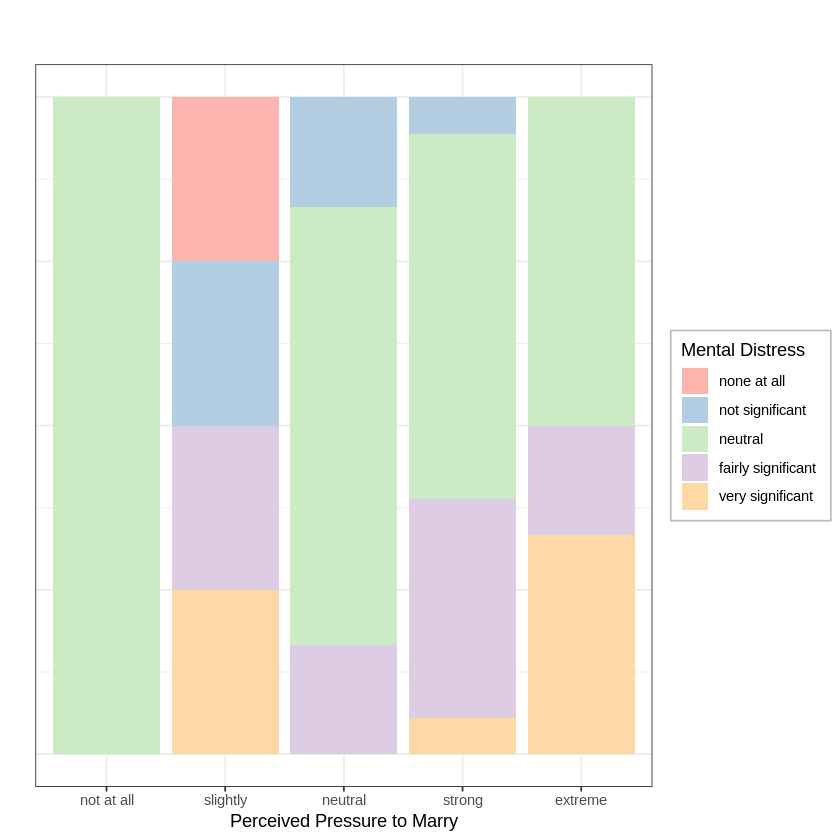

In [139]:
bar5 <- ggplot(sur_clean %>% filter(!is.na(pressure_marr)) %>% filter(!is.na(mental)),
                aes(x = pressure_marr, fill = mental)) +
  geom_bar(position = "fill", width = 0.9) +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "",
       subtitle = "",
       x = "Perceived Pressure to Marry",
       y = "",
       fill = "Mental Distress") +
  theme_bw() +
  theme(
      panel.background = element_rect(fill = "white", color = NA), # white plot area
      plot.background = element_rect(fill = NA, color = NA),
      #legend.position = "none",
      axis.text.y = element_blank(),
      axis.ticks.y = element_blank(),
      legend.box.just = "left",
      legend.margin = margin(6, 6, 6, 6),
      legend.background = element_rect(fill = "white", color = "#BDBDBD"))

bar5

In [140]:
ggsave("poster_6_legend.png", plot = bar5, width = 4, height = 5, units = "in", bg = "transparent")

In [ ]:
press_mental_table <- table(sur_clean$pressure_marr, sur_clean$mental)
chi_test_result_2 <- chisq.test(press_mental_table)

print(chi_test_result_2)
assocstats(press_mental_table)

# sig, mod

Warning message in chisq.test(press_mental_table):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  press_mental_table
X-squared = 26.838, df = 16, p-value = 0.04331



                    X^2 df P(> X^2)
Likelihood Ratio 24.183 16 0.085584
Pearson          26.838 16 0.043315

Phi-Coefficient   : NA 
Contingency Coeff.: 0.599 
Cramer's V        : 0.374 

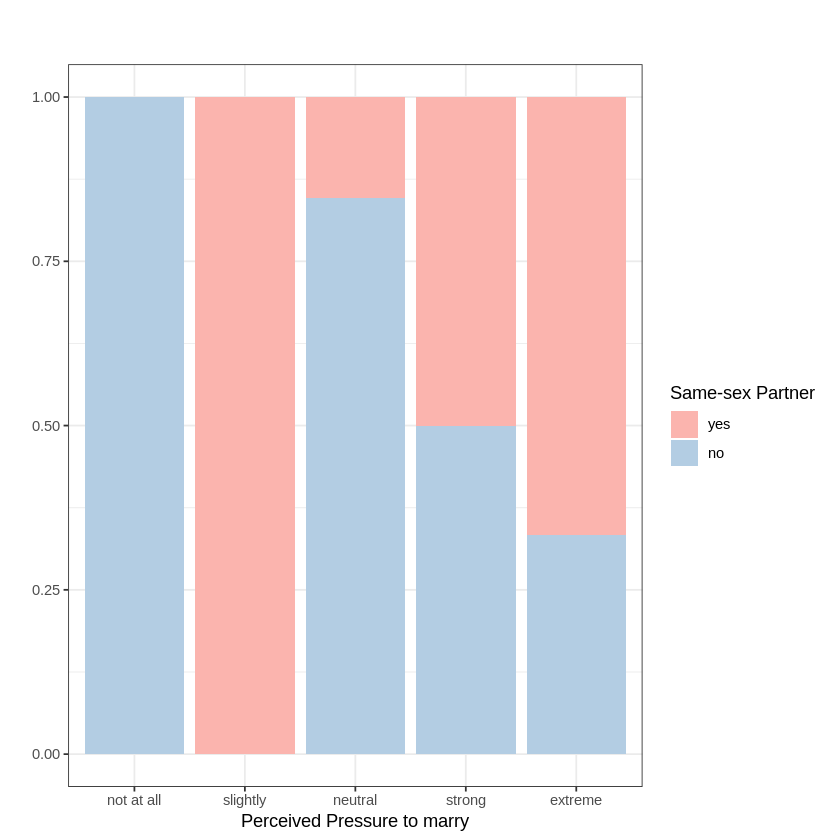

In [ ]:
sur_clean$partner <- factor(sur_clean$partner, levels = c("yes", "no"))

bar6 <- ggplot(sur_clean %>% filter(!is.na(pressure_marr)) %>% filter(!is.na(partner)),
                aes(x = pressure_marr, fill = partner)) +
  geom_bar(position = "fill", width = 0.9) +
  scale_fill_brewer(palette = "Pastel1") +
  labs(title = "",
       subtitle = "",
       x = "Perceived Pressure to marry",
       y = "",
       fill = "Same-sex Partner") +
  theme_bw()

bar6

In [ ]:
table <- table(sur_clean$pressure_marr, sur_clean$partner)
results <- chisq.test(table)

print(results)
assocstats(table)

# sig, str

Warning message in chisq.test(table):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  table
X-squared = 13.431, df = 4, p-value = 0.009352



                    X^2 df  P(> X^2)
Likelihood Ratio 16.353  4 0.0025808
Pearson          13.431  4 0.0093520

Phi-Coefficient   : NA 
Contingency Coeff.: 0.464 
Cramer's V        : 0.524 

`geom_smooth()` using formula = 'y ~ x'


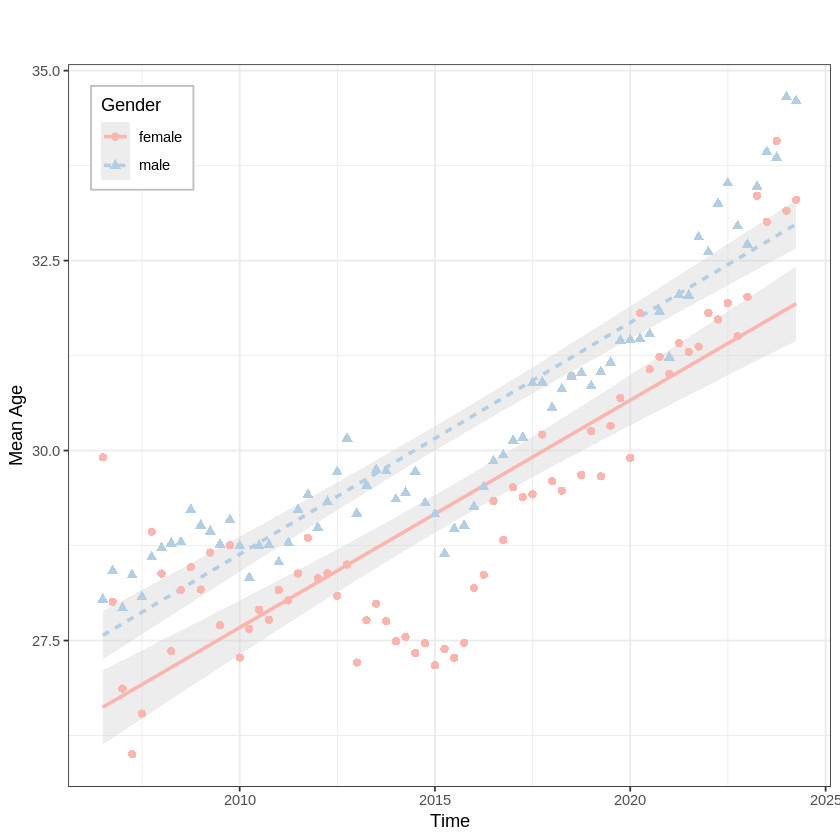

In [130]:
######################### age temporal shift #########################
# or use mid_age for median
user3 <- ggplot(cgl_shft_age %>% filter(!is.na(mean_age)), aes(x = quarter, y = mean_age, group = gender)) +
  #geom_line(aes(linetype = gender, color = gender)) +
  geom_smooth(method = lm, aes(color = gender, linetype = gender), fill = "light grey", alpha = 0.4) +
  geom_point(aes(shape = gender, color = gender), size = 2) +
  labs(title = "",
       subtitle = "",
       x = "Time",
       y = "Mean Age",
       linetype = "Gender",
       shape = "Gender",
       color = "Gender") +
  scale_color_brewer(palette = "Pastel1") +
  theme_bw() +
  theme(
      panel.background = element_rect(fill = "white", color = NA), # white plot area
      plot.background = element_rect(fill = NA, color = NA),
      legend.position = c(.03, .97),
      legend.justification = c("left", "top"),
      legend.box.just = "left",
      legend.margin = margin(6, 6, 6, 6),
      legend.background = element_rect(fill = "white", color = "#BDBDBD"))
user3

In [131]:
ggsave("poster_3.png", plot = user3, width = 4, height = 4, units = "in", bg = "transparent")

`geom_smooth()` using formula = 'y ~ x'


In [ ]:
cgl_stat_age<- cgl_shft_age %>%
  ungroup() %>%
  subset(gender == "female") %>%
  select(quarter, mean_age) %>%
  rename("female_age" = "mean_age")

cgl_stat_age_male <- cgl_shft_age %>%
  ungroup() %>%
  subset(gender == "male") %>%
  select(quarter, mean_age) %>%
  rename("male_age" = "mean_age")

cgl_stat_age <- left_join(cgl_stat_age, cgl_stat_age_male, join_by(quarter)) %>%
  filter(!is.na(quarter))

mean_female <- mean(cgl_stat_age$female_age, na.rm = T)
mean_male <- mean(cgl_stat_age$male_age, na.rm = T)

lm_female <- lm(formula = female_age ~ quarter, data = cgl_stat_age)
lm_male <- lm(formula = male_age ~ quarter, data = cgl_stat_age)

In [ ]:
t.test(cgl_stat_age$male_age, cgl_stat_age$female_age)


	Welch Two Sample t-test

data:  cgl_stat_age$male_age and cgl_stat_age$female_age
t = 3.306, df = 141.04, p-value = 0.0012
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4005262 1.5920476
sample estimates:
mean of x mean of y 
 30.14902  29.15274 


`summarise()` has grouped output by 'quarter'. You can override using the
`.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


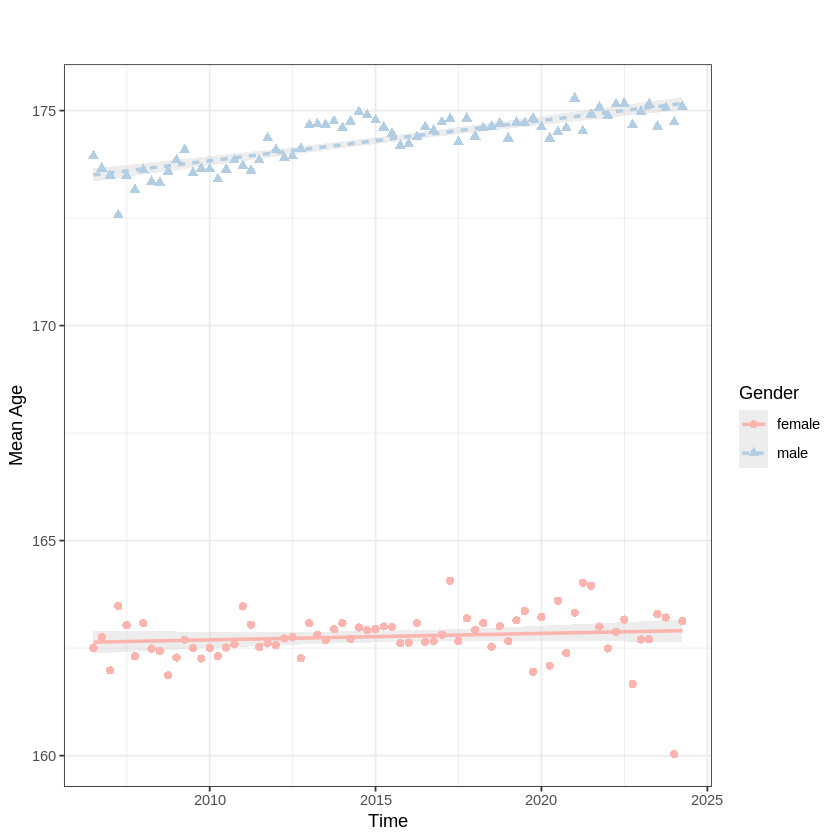

In [ ]:
cgl_shft_height <- cgl_totl %>%
  group_by(quarter, gender) %>%
  summarize(mean_height = mean(height, na.rm = TRUE))

ggplot(cgl_shft_height %>% filter(!is.na(quarter)), aes(x = quarter, y = mean_height, group = gender)) +
  #geom_line(aes(linetype = gender, color = gender)) +
  geom_smooth(method = lm, aes(color = gender, linetype = gender), fill = "light grey", alpha = 0.4) +
  geom_point(aes(shape = gender, color = gender), size = 2) +
  labs(title = "",
       subtitle = "",
       x = "Time",
       y = "Mean Age",
       linetype = "Gender",
       shape = "Gender",
       color = "Gender") +
  scale_color_brewer(palette = "Pastel1") +
  theme_bw()

`geom_smooth()` using formula = 'y ~ x'


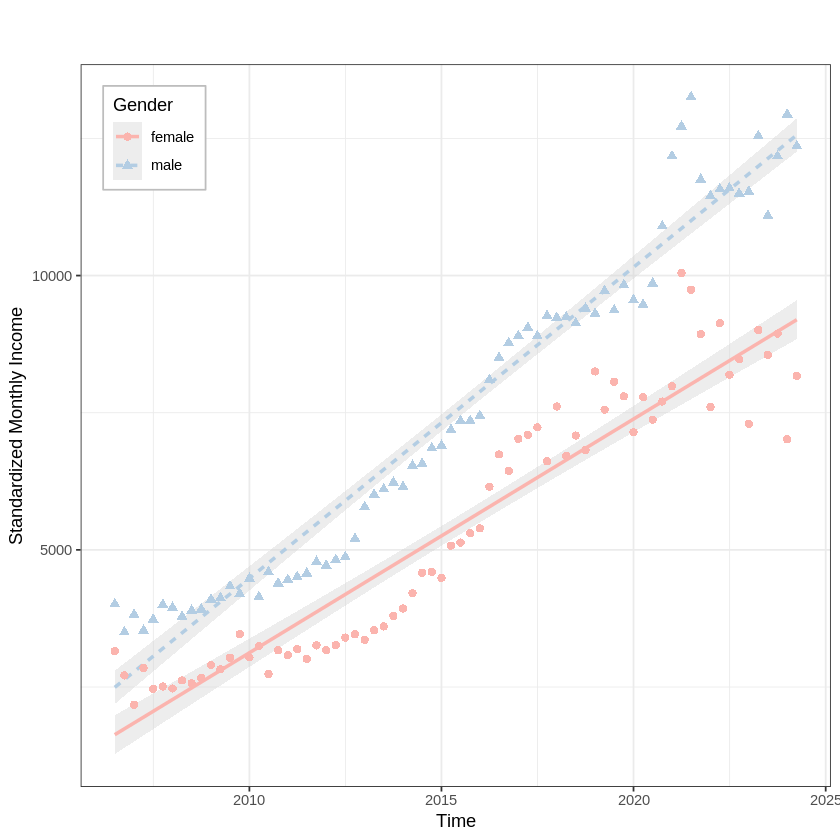

In [132]:
user4 <- ggplot(cgl_shft_income %>% filter(!is.na(date)), aes(x = date, y = adj_income, group = gender)) +
  #geom_line(aes(linetype = gender, color = gender)) +
  geom_smooth(method = lm, aes(color = gender, linetype = gender), fill = "light grey", alpha = 0.4) +
  geom_point(aes(shape = gender, color = gender), size = 2) +
  labs(title = "",
       subtitle = "",
       x = "Time",
       y = "Standardized Monthly Income",
       linetype = "Gender",
       shape = "Gender",
       color = "Gender") +
  scale_color_brewer(palette = "Pastel1") +
  theme_bw() +
  theme(
      panel.background = element_rect(fill = "white", color = NA), # white plot area
      plot.background = element_rect(fill = NA, color = NA),
      legend.position = c(.03, .97),
      legend.justification = c("left", "top"),
      legend.box.just = "left",
      legend.margin = margin(6, 6, 6, 6),
      legend.background = element_rect(fill = "white", color = "#BDBDBD"))

user4

In [133]:
ggsave("poster_4.png", plot = user4, width = 4, height = 4, units = "in", bg = "transparent")

`geom_smooth()` using formula = 'y ~ x'


In [ ]:
cgl_stat_inc<- cgl_shft_income %>%
  ungroup() %>%
  subset(gender == "female") %>%
  select(date, adj_income) %>%
  rename("female_inc" = "adj_income")

cgl_stat_inc_male <- cgl_shft_income %>%
  ungroup() %>%
  subset(gender == "male") %>%
  select(date, adj_income) %>%
  rename("male_inc" = "adj_income")

cgl_stat_inc <- left_join(cgl_stat_inc, cgl_stat_inc_male, join_by(date)) %>%
  filter(!is.na(date))

lm_female <- lm(formula = female_inc ~ date, data = cgl_stat_inc)
lm_male <- lm(formula = male_inc ~ date, data = cgl_stat_inc)

In [ ]:
t.test(cgl_stat_inc$female_inc, cgl_stat_inc$male_inc)


	Welch Two Sample t-test

data:  cgl_stat_inc$female_inc and cgl_stat_inc$male_inc
t = -4.669, df = 133.68, p-value = 7.273e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3010.280 -1218.775
sample estimates:
mean of x mean of y 
 5413.629  7528.157 


In [ ]:
summary(lm_female)
summary(lm_male)


Call:
lm(formula = female_inc ~ date, data = cgl_stat_inc)

Residuals:
     Min       1Q   Median       3Q      Max 
-2073.58  -561.42     7.06   418.28  2128.58 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.392e+04  7.889e+02  -17.64   <2e-16 ***
date         1.167e+00  4.730e-02   24.67   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 761.6 on 70 degrees of freedom
Multiple R-squared:  0.8968,	Adjusted R-squared:  0.8953 
F-statistic: 608.4 on 1 and 70 DF,  p-value: < 2.2e-16



Call:
lm(formula = male_inc ~ date, data = cgl_stat_inc)

Residuals:
    Min      1Q  Median      3Q     Max 
-1044.5  -422.8  -120.7   325.8  2252.7 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.821e+04  6.758e+02  -26.94   <2e-16 ***
date         1.553e+00  4.052e-02   38.33   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 652.4 on 70 degrees of freedom
Multiple R-squared:  0.9545,	Adjusted R-squared:  0.9539 
F-statistic:  1469 on 1 and 70 DF,  p-value: < 2.2e-16


In [ ]:
############################## word freq ##############################
# exclusoin words

exclusion <- c("婚", "式", "婚对象", "TA还没有填写形婚期望", "你可以私信给TA进一步了解", "XH", 0:99, "ฅฅ",
                "愿你是一位善良真诚爱家的女人让我们共创一个和和美美温馨甜蜜的小家最好婚后能要个小孩我很喜欢小孩的来信必复",
                "希望","可以","最好","我们","对方","以上","一起","不要", readLines("stopper.txt", encoding = "UTF-8"))

######################### word freq simple #########################

countWords <- function(dat, colname, exclusion) {
  dat[[colname]] <- dat[[colname]] %>%
    str_replace_all("[[:punct:]]", "") %>%
    str_replace_all("[a-zA-Z]", "") %>%
    str_replace_all("[0-9]", "")

  split_words <- str_split(dat[[colname]], "\\W+")
  words <- unlist(split_words)[words != ""]

  freq <- table(words)
  freq_df <- as.data.frame(freq) %>%
    arrange(desc(Freq)) %>%
    mutate(words = as.character(words)) %>%
    filter(!words %in% exclusion) %>%         # no exluded words
    filter(!words == "") %>%                  # no empty
    filter(nchar(words) > 1)                  # no single character

  return(freq_df)
}

######################### word freq temporal #########################

library(jiebaR)
library(dplyr)
library(stringr)
library(lubridate)

countWordsByAge <- function(dat, colname, exclusion, age_col, age_intervals) {
  segmenter <- worker(type = "mix")

  dat <- dat %>%
    mutate(age_group = cut(!!sym(age_col), breaks = age_intervals, right = FALSE, include.lowest = TRUE))

  freq_list <- list()
  unique_age_groups <- unique(dat$age_group)

  for (age_grp in unique_age_groups) {
    subset_dat <- dat %>% filter(age_group == age_grp)
    total_samples <- nrow(subset_dat)

    concatenated_text <- paste(subset_dat[[colname]], collapse = " ")
    segmented_words <- segment(concatenated_text, segmenter)
    segmented_words <- segmented_words[!str_detect(segmented_words, "[[:punct:]]|[a-zA-Z]|[0-9]")]

    freq <- table(segmented_words)
    freq_df <- as.data.frame(freq) %>%
      arrange(desc(Freq)) %>%
      mutate(words = as.character(segmented_words)) %>%
      filter(!words %in% exclusion) %>%
      filter(words != "") %>%
      filter(nchar(words) > 1) %>%
      mutate(age_group = as.character(age_grp),
             standardized_freq = Freq / total_samples)

    freq_list[[as.character(age_grp)]] <- freq_df
  }

  combined_freq_df <- bind_rows(freq_list)
  return(combined_freq_df)
}

Warning message in readLines("stopper.txt", encoding = "UTF-8"):
“incomplete final line found on 'stopper.txt'”


ERROR: Error in library(jiebaR): there is no package called ‘jiebaR’


In [ ]:
######################### freq vs. age group raster #########################

library(repr)
#install.packages("extrafont")
#library(extrafont)
library(ragg)
#library(sysfonts)
#library(showtext)
#showtext_auto()

#options(repr.plot.width = 10, repr.plot.height = 10)

#font_path <- "/content/drive/MyDrive/AAFT_Draft/Data/SimHei.ttf"
#font_import(paths = dirname(font_path), pattern = basename(font_path), prompt = FALSE) #chinese font
#loadfonts()

In [ ]:
age_intervals <- seq(20, 45, by = 1)
cgl_totl_freq <- countWordsByAge(cgl_totl, "exp", exclusion, "age_adj", age_intervals)

In [ ]:
cgl_totl_word <- countWords(cgl_totl, "exp", exclusion)

In [ ]:
write.csv(cgl_totl_word, "cgl_freq.csv", row.names = F)

In [ ]:
top_words <- cgl_totl_freq %>%
  group_by(words) %>%
  summarize(total_freq = sum(standardized_freq)) %>%
  arrange(desc(total_freq)) %>%
  slice_head(n = 15) %>% # get top 40 words
  pull(words)

top_word_freq <- cgl_totl_freq %>%
  filter(words %in% top_words)

# plot
ggplot(top_word_freq, aes(x = age_group, y = words, fill = standardized_freq)) +
  geom_raster() +
  coord_fixed() +
  scale_fill_gradient2() +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90)) +
  labs(title = "Top 15 Words by Standardized Frequency Across Age Groups",
       x = "Age Group",
       y = "Frequent Words",
       fill = "Standardized Frequency")

In [ ]:
######################### xhl profiles #########################

xhl_profiles <- read.csv("web1/profilesCleaned.csv")

######################### xhl posts #########################

xhl_posts <- read.csv("web1/postsCleaned.csv")



In [ ]:
# survey data
sur <- read.csv("/content/drive/MyDrive/AAFT_Draft/Data/survey/sur.csv")

sur_clean <- sur[5:11]

colnames(sur_clean) <- c("age", "gender", "orientation", "partner", "edu", "marr", "income")
sur_clean$sham <- sur[,37]

# age
sur_clean$age <- gsub("17", "under 17",
              gsub(" ", "",
                  gsub("or below", "",
                    gsub("years old", "", sur_clean$age))))


# edu
sur_clean$edu <- sur_clean$edu %>%
  tolower() %>%
  factor(levels = c("middle school and below",
                        "high school and/or associate",
                        "college associate",
                        "college",
                        "master and above")) # different education

# income
sur_clean$income <- sur_clean$income %>%
  tolower()
sur_clean$income <- gsub("0000", "0k",
                  gsub("cny", "", sur_clean$income))
sur_clean$income <- gsub("000", "k", sur_clean$income)


# gender
sur_clean$gender <- sur_clean$gender %>%
  tolower() %>%
  factor(levels = c("female", "male", "non-binary"))

# sham status discrete
sur_clean$sham <- gsub("No, but willing to enter a sham marriage and currently looking for a partner", "planning",
          gsub("No, but have already found a partner", "have partner",
              gsub("Yes", "sham-married", sur_clean$sham)))

# mental impact
sur <- rename("mental" = "X29.How.significant.do.you.feel.that.issues.related.to.a.sham.marriage.have.had.a.negative.impact.on.your.mental.health.", sur)
sur_clean$mental <- sur$mental %>%
  tolower()
sur_clean$mental <- gsub("not very significant", "not significant", sur_clean$mental)

# if_will
sur <- rename("if_will" = "X32.If.there.were.no.family.or.societal.expectations.and.pressures..or.if.you.had.family.support...would.you.choose.a.sham.marriage.", sur)
sur_clean$if_will <- sur$if_will %>%
  tolower()

# others
sur_clean$orientation <- tolower(sur_clean$orientation)
sur_clean$marr <- tolower(sur_clean$marr)
sur_clean$partner <- tolower(sur_clean$partner)

In [ ]:
# saving progress

write.csv(cgl, "survey/cgl_total.csv")
write.csv(cgl_active, "survey/cgl_active.csv")
#write.csv(xhl_profiles, "survey/xhl_profiles.csv")
#write.csv(xhl_posts, "survey/xhl_posts.csv")

#setwd("/content/drive/MyDrive/AAFT_Draft/Data/survey")
#write.csv(sur_clean, "sur_clean.csv")

In [ ]:
# various understandings for sham marriages
# motivation for sham marriages
#